# Import 

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression #Linear regression proc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.feature_selection import RFE #Recursive Feature Elimination -Selects variables based on performance in model.

# Any results you write to the current directory are saved as output.
from subprocess import check_output

# Import packages to use for data exploration (graphs/plots)
import seaborn as sns
import scipy as sp
# Get function to calculate SpearmanR coefficient.
from scipy.stats import spearmanr

# Makes your plots appear in your notebook instead of creating a file somewhere
%matplotlib inline

#Import module to create our training and test sets.
from sklearn.model_selection import train_test_split

# Bob XG Boost Imports
import xgboost as xgb
# Label encoder can be used to normalize labels and to transform non-numerical
# labels to numeric, as long as they are hashable and comparable.  
# See: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# Hashable means that for every unique input to a function, you get a unique 
# out.  See: https://www.quora.com/What-are-hashable-types-in-Python
from sklearn.preprocessing import LabelEncoder
# The TransformerMixin defines the fit and transform methods for our
# data transformer... We could write those methods ourselves, but this helps to 
# ensure that we maintain compatibility with sklearn.  For more info see:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
from sklearn.base import TransformerMixin

In [2]:
# Import Altair for Data Vis
!pip install altair==2.0.0rc2
import altair as alt
# for colab only run this command once per session
alt.renderers.enable('colab')


    100% |████████████████████████████████| 266kB 2.8MB/s 
    100% |████████████████████████████████| 194kB 3.8MB/s 
    100% |████████████████████████████████| 51kB 5.8MB/s 
    100% |████████████████████████████████| 204kB 3.7MB/s 
    100% |████████████████████████████████| 92kB 7.1MB/s 
    100% |████████████████████████████████| 51kB 8.1MB/s 
  Running setup.py bdist_wheel for altair ... done
  Stored in directory: /content/.cache/pip/wheels/1a/fd/6c/d83abf77763e110962c7e9a03c73e335aa0a24c5c897268683
  Running setup.py bdist_wheel for toolz ... done
  Stored in directory: /content/.cache/pip/wheels/f4/0c/f6/ce6b2d1aa459ee97cc3c0f82236302bd62d89c86c700219463
  Running setup.py bdist_wheel for vega-datasets ... done
  Stored in directory: /content/.cache/pip/wheels/0e/62/0f/5e6640ba8fe195498b8567f7d7f0a8d588e3af64a3a23da30e
Successfully built altair toolz vega-datasets
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip i

In [5]:
# Import files.
# This worked by hitting the execute button, and THEN selecting the files from the "Choose Files" button.
# Every person working on this needs to upload the data files from their computer

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving df_test2.csv to df_test2 (1).csv
Saving df_train2.csv to df_train2 (1).csv
Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "df_test2.csv" with length 21767 bytes
User uploaded file "df_train2.csv" with length 43771 bytes
User uploaded file "test.csv" with length 28629 bytes
User uploaded file "train.csv" with length 61194 bytes


In [0]:
# Create Data Frames

# Test Data
df_test = pd.read_csv('./test.csv')
df_test2 = pd.read_csv('./df_test2.csv')

# Train Data
df_train = pd.read_csv('./train.csv')
df_train2 = pd.read_csv('./df_train2.csv')


In [0]:
# Create test and training set.

# Create training and test sets for the data.
# df_train2, df_test2 = train_test_split(df_train, test_size=0.33)

# df_train2.to_csv('df_train2.csv')
# df_test2.to_csv('df_test2.csv')
# DOWNLOAD FILES FROM COLLABORATRORY
# files.download('df_train2.csv')
# files.download('df_test2.csv')

# EDA Exploratory Data Analysis

In [0]:
df_train2.head(20)

# Passengers over age 1 who have estimated ages
df_train2[(df_train2['Age'] > 1) & ((df_train2["Age"] % 1) > 0)].count()

# Passengers with Siblings or Spouses
df_train2[df_train2["SibSp"] > 0].sort_values(by="Name")

df_train2[df_train2["Embarked"] == "S"]

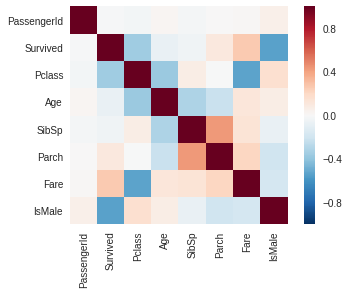

In [76]:
##Correlation heatmap
sns.heatmap(df_train2.corr(), square=True);

In [24]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 17 columns):
Unnamed: 0     596 non-null int64
PassengerId    596 non-null int64
Survived       596 non-null int64
Pclass         596 non-null int64
Name           596 non-null object
Sex            596 non-null object
Age            487 non-null float64
SibSp          596 non-null int64
Parch          596 non-null int64
Ticket         596 non-null object
Fare           596 non-null float64
Cabin          141 non-null object
Embarked       595 non-null object
FareRange      582 non-null category
IsMale         596 non-null float64
AgeRange       487 non-null category
ClassSexAge    596 non-null object
dtypes: category(2), float64(3), int64(6), object(6)
memory usage: 71.5+ KB


# Feature Engineering

In [0]:
# Since there are many NULL ages, I will impute missing ages based on the average age of similar passengers.
# I will group Sex, SibSp, Parch and Pclass to get averages for groups -the assumption is that if these demos are similar than age may be, as well.
# Effectively, this gives me an average age for:
  # "Lower class men with no children/parents or spouse/sibling on board"
  # "Middle class women with no children and one spouse/sibling on board"
  # Etc...


# TRAIN DATA
# Create df with only passengers that have age so we can get averages.
df_trainAge = df_train2.loc[df_train2['Age'].isnull() == 0].copy(deep=True)

# Create new df that groups columns and gets average age by group.
# reset_index reverts the output back to a table that can be easily joined.  Otherwise,. the indexes would be offset.
df_trainAge2 = df_trainAge[['Sex', 'SibSp', 'Parch', 'Pclass', 'Age']].groupby(['Sex', 'SibSp', 'Parch', 'Pclass']).mean().reset_index()

# Merge the new average column back in with the others.
df_train3 = pd.merge(left=df_train2, right=df_trainAge2, how='left', on=['Sex', 'SibSp', 'Parch', 'Pclass'])

# Update Age column with the average is the Age column is null.
df_train3['Age_x'] = np.where(df_train3['Age_x'].isnull(),df_train3['Age_y'], df_train3['Age_x'])


# Clean up by dropping Age_y and renaming Age_x to Age.
df_train3.drop(labels=['Age_y'], inplace=True, axis=1)
df_train3 = df_train3.rename(columns={'Age_x':'Age'})



In [0]:
# Create bins for Fare.
df_train3['FareRange'] = pd.cut(df_train3['Fare'], [0, 8, 13, 26, 60, 110, 150, 600])

In [0]:
# Set gender to a binary.
df_train3.loc[df_train3['Sex'] == 'female', 'IsMale'] = 0
df_train3.loc[df_train3['Sex'] == 'male', 'IsMale'] = 1

In [0]:
# Create bins for Age.
df_train3['AgeRange'] = pd.cut(df_train3['Age'], [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85]);

In [0]:
# Create variable to put AgeRange, Pclass and Sex into categories.
df_train3['ClassSexAge'] = df_train3['Pclass'].astype(str) + df_train3['Sex'] + df_train3['AgeRange'].astype(str)

In [0]:
# Set flag to determine if passenger has any family on board or none.
df_train3['HasFamilyOnboard'] = np.where((df_train3['SibSp'] + df_train3['Parch']) > 0, 1, 0) 

In [0]:
# Set binary to determine if passenger has a cabin or not.
df_train3.loc[df_train3['Cabin'].isnull() == 1, 'HasCabin'] = 0
df_train3.loc[df_train3['Cabin'].isnull() == 0, 'HasCabin'] = 1

In [194]:

df_train3.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareRange,IsMale,AgeRange,ClassSexAge,HasFamilyOnboard,HasCabin
0,369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.000000,0,0,PC 17477,69.300,B35,C,"(60, 110]",0.0,"(20, 25]","1female(20, 25]",0,1.0
1,348,349,1,3,"Coutts, Master. William Loch ""William""",male,3.000000,1,1,C.A. 37671,15.900,NaN,S,"(13, 26]",1.0,"(0, 5]","3male(0, 5]",1,0.0
2,816,817,0,3,"Heininen, Miss. Wendla Maria",female,23.000000,0,0,STON/O2. 3101290,7.925,NaN,S,"(0, 8]",0.0,"(20, 25]","3female(20, 25]",0,0.0
3,264,265,0,3,"Henry, Miss. Delia",female,23.766667,0,0,382649,7.750,NaN,Q,"(0, 8]",0.0,"(20, 25]","3female(20, 25]",0,0.0
4,805,806,0,3,"Johansson, Mr. Karl Johan",male,31.000000,0,0,347063,7.775,NaN,S,"(0, 8]",1.0,"(30, 35]","3male(30, 35]",0,0.0


## Post Feature Engineering EDA

In [99]:
df_train3.groupby(['ClassSexAge','Survived']).size()


ClassSexAge      Survived
1female(0, 5]    0            1
1female(15, 20]  1           10
1female(20, 25]  0            1
                 1            7
1female(25, 30]  1            6
1female(30, 35]  1           10
1female(35, 40]  1           12
1female(40, 45]  1            4
1female(45, 50]  0            1
                 1            5
1female(50, 55]  1            5
1female(55, 60]  1            4
1female(60, 65]  1            2
1male(0, 5]      1            2
1male(10, 15]    1            1
1male(15, 20]    0            2
1male(20, 25]    0            4
                 1            1
1male(25, 30]    0            4
                 1            4
1male(30, 35]    0            2
                 1            5
1male(35, 40]    0            5
                 1            5
1male(40, 45]    0           11
                 1            6
1male(45, 50]    0           10
                 1            3
1male(50, 55]    0            4
                 1            2
              

In [101]:
df_train3.groupby(['IsMale','HasFamilyOnboard','Survived']).size()

IsMale  HasFamilyOnboard  Survived
0.0     0                 0            18
                          1            69
        1                 0            31
                          1            86
1.0     0                 0           232
                          1            44
        1                 0            82
                          1            34
dtype: int64

In [102]:
df_train3.groupby(['IsMale','AgeRange','Survived']).size()

IsMale  AgeRange  Survived
0.0     (0, 5]    0            2
                  1           12
        (5, 10]   0            6
                  1            2
        (10, 15]  0            3
                  1            3
        (15, 20]  0            8
                  1           20
        (20, 25]  0           12
                  1           32
        (25, 30]  0            8
                  1           20
        (30, 35]  0            1
                  1           23
        (35, 40]  0            3
                  1           15
        (40, 45]  0            2
                  1            8
        (45, 50]  0            2
                  1            8
        (50, 55]  1            5
        (55, 60]  0            1
                  1            4
        (60, 65]  1            3
1.0     (0, 5]    0            7
                  1           14
        (5, 10]   0            4
                  1            3
        (10, 15]  0            3
                

In [103]:
df_train3.groupby(['FareRange','Survived']).size()

FareRange   Survived
(0, 8]      0           111
            1            34
(8, 13]     0            93
            1            34
(13, 26]    0            61
            1            48
(26, 60]    0            56
            1            60
(60, 110]   0            21
            1            31
(110, 150]  0             3
            1            11
(150, 600]  0             5
            1            14
dtype: int64

# Ben's Playground

Because of the way I created all of these extra categorical variables, I'll need to change them into "dummy" variables so that the algorithm can use them in computation.  Remember:  Categorical variables aren't numeric so you can't do math with them, which is what the algorithm needs to do. A dummy variable is when you take each possible category from a categorical variable and convert it to it's own binary.  This, instead of being varchars that the algo can't do anything with, gives the algo a 0 or 1 representation of every record as in or out of each category in the categorical variable.

In [0]:
# First, drop columns I don't need.

df_train4 = df_train3.copy(deep=True)

df_train4.drop(labels=['Unnamed: 0','PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'IsMale'], inplace=True, axis=1)

df_train4 = pd.get_dummies(df_train4)


In [126]:
df_train4.head()

,Survived,HasFamilyOnboard,HasCabin,"FareRange_(0, 8]","FareRange_(8, 13]","FareRange_(13, 26]","FareRange_(26, 60]","FareRange_(60, 110]","FareRange_(110, 150]","FareRange_(150, 600]",...,"ClassSexAge_3male(30, 35]","ClassSexAge_3male(35, 40]","ClassSexAge_3male(40, 45]","ClassSexAge_3male(45, 50]","ClassSexAge_3male(5, 10]","ClassSexAge_3male(50, 55]","ClassSexAge_3male(55, 60]","ClassSexAge_3male(60, 65]","ClassSexAge_3male(70, 75]",ClassSexAge_3malenan
0,1,0,1.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


#### Final Data Prep for Modeling

First, I need to prep my test data exactly the way I did my train data.  This time I use the original, unsplit test file.

In [0]:

# TEST DATA

# Create df with only passengers that have age so we can get averages.
df_testAge = df_test.loc[df_test['Age'].isnull() == 0].copy(deep=True)

# Create new df that groups columns and gets average age by group.
# reset_index reverts the output back to a table that can be easily joined.  Otherwise,. the indexes would be offset.
df_testAge2 = df_testAge[['Sex', 'SibSp', 'Parch', 'Pclass', 'Age']].groupby(['Sex', 'SibSp', 'Parch', 'Pclass']).mean().reset_index()

# Merge the new average column back in with the others.
df_test3 = pd.merge(left=df_test, right=df_testAge2, how='left', on=['Sex', 'SibSp', 'Parch', 'Pclass'])

# Update Age column with the average is the Age column is null.
df_test3['Age_x'] = np.where(df_test3['Age_x'].isnull(),df_test3['Age_y'], df_test3['Age_x'])


# Clean up by dropping Age_y and renaming Age_x to Age.
df_test3.drop(labels=['Age_y'], inplace=True, axis=1)
df_test3 = df_test3.rename(columns={'Age_x':'Age'})

# Create bins for Fare.
df_test3['FareRange'] = pd.cut(df_test3['Fare'], [0, 8, 13, 26, 60, 110, 150, 600])

# Set gender to a binary.
df_test3.loc[df_test3['Sex'] == 'female', 'IsMale'] = 0
df_test3.loc[df_test3['Sex'] == 'male', 'IsMale'] = 1


# Create bins for Age.
df_test3['AgeRange'] = pd.cut(df_test3['Age'], [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85]);

# Create variable to put AgeRange, Pclass and Sex into categories.
df_test3['ClassSexAge'] = df_test3['Pclass'].astype(str) + df_test3['Sex'] + df_test3['AgeRange'].astype(str)


# Set flag to determine if passenger has any family on board or none.
df_test3['HasFamilyOnboard'] = np.where((df_test3['SibSp'] + df_test3['Parch']) > 0, 1, 0) 


# Set binary to determine if passenger has a cabin or not.
df_test3.loc[df_test3['Cabin'].isnull() == 1, 'HasCabin'] = 0
df_test3.loc[df_test3['Cabin'].isnull() == 0, 'HasCabin'] = 1


# First, drop columns I don't need.

df_test4 = df_test3.copy(deep=True)

# Keep PassengerID this time so we can rejoin the prediction to the file
df_test4.drop(labels=['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'IsMale'], inplace=True, axis=1)

df_test4 = pd.get_dummies(df_test4)

In [206]:
df_test4.head()

,PassengerId,HasFamilyOnboard,HasCabin,"FareRange_(0, 8]","FareRange_(8, 13]","FareRange_(13, 26]","FareRange_(26, 60]","FareRange_(60, 110]","FareRange_(110, 150]","FareRange_(150, 600]",...,"ClassSexAge_3male(15, 20]","ClassSexAge_3male(20, 25]","ClassSexAge_3male(25, 30]","ClassSexAge_3male(30, 35]","ClassSexAge_3male(35, 40]","ClassSexAge_3male(40, 45]","ClassSexAge_3male(45, 50]","ClassSexAge_3male(5, 10]","ClassSexAge_3male(60, 65]",ClassSexAge_3malenan
0,892,0,0.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,893,1,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,894,0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,895,0,0.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,896,1,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can prep for the modeling.

In [0]:
# Create an array with all of the predictors I want (Be sure to exclude the target!).
data_variables=df_train4.columns.values.tolist()
t = ['Survived']
cols=[i for i in data_variables if i not in t]

# Use the array I just created wih the column names to prep my input for my model, separating predictors and target.
# Note:  This is a very common format using big-X for my predictors and small-y for my target.

X=df_train4[cols]
y=df_train4[t]


In [0]:
X = X.astype('float64')
y = y.astype('float64')

### Logistic Regression with SKLearn.

The first one is just to show what my training data got me.  The second one gives me my actual predictions.

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X, y)
y_pred = logreg.predict(X)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [208]:
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X, y)))

Accuracy of logistic regression classifier on train set: 0.85


In [203]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y, y_pred)
print(confusion_matrix)

[[337  26]
 [ 66 167]]


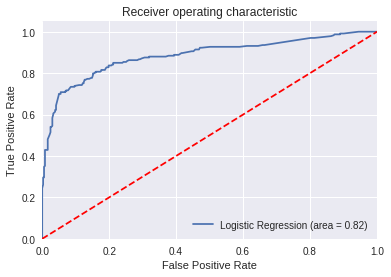

In [204]:
# ROC Curve
# The ROC curve measures the tradeoff between selecting as many True Positives as possible while avoiding False Positives.
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y, logreg.predict(X))
fpr, tpr, thresholds = roc_curve(y, logreg.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

##### Final Model and Predictions

In [0]:
# Find and drop any columns that are in one set and not the other.
# There are some combinations of the ClassSexAge variable that are not in either the train or test files.  It will cause an error if I try to model with mismatched columns.

traincols = X.columns
testcols = df_test4.columns

missingcols1 = list(set(traincols) - set(testcols))

missingcols2 = list(set(testcols) - set(traincols))


In [241]:

print(missingcols1)

['ClassSexAge_1male(0, 5]', 'ClassSexAge_1male(75, 80]', 'ClassSexAge_3female(10, 15]', 'ClassSexAge_3male(55, 60]', 'ClassSexAge_3male(50, 55]', 'ClassSexAge_2male(50, 55]', 'ClassSexAge_1female(0, 5]', 'ClassSexAge_3female(60, 65]', 'ClassSexAge_1male(70, 75]', 'ClassSexAge_2male(65, 70]', 'ClassSexAge_3male(70, 75]']


In [242]:
print(missingcols2)

['ClassSexAge_2male(10, 15]', 'ClassSexAge_1female(75, 80]', 'PassengerId', 'ClassSexAge_1male(5, 10]', 'ClassSexAge_1male(65, 70]']


In [0]:

X.drop(labels=['ClassSexAge_1male(0, 5]', 'ClassSexAge_1male(75, 80]', 'ClassSexAge_3female(10, 15]', 'ClassSexAge_3male(55, 60]', 'ClassSexAge_3male(50, 55]', 'ClassSexAge_2male(50, 55]', 'ClassSexAge_1female(0, 5]', 'ClassSexAge_3female(60, 65]', 'ClassSexAge_1male(70, 75]', 'ClassSexAge_2male(65, 70]', 'ClassSexAge_3male(70, 75]'], inplace=True, axis=1)

df_test4.drop(labels=['ClassSexAge_2male(10, 15]', 'ClassSexAge_1female(75, 80]', 'PassengerId', 'ClassSexAge_1male(5, 10]', 'ClassSexAge_1male(65, 70]'], inplace=True, axis=1)



In [250]:
# Setting what we created above to a more recognizable name.
X_test = df_test4

  # NOTE: I'm using the same X and y from above, but with the mismatched columns removed from X.

# This will run the model and give me an accuracy score at the bottom.
logreg = LogisticRegression()
logreg.fit(X, y)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X, y) * 100, 2)
acc_log

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


84.56

In [0]:
logreg = LogisticRegression()
logreg.fit(X, y)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log


In [0]:
# Prep my submission

submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_pred
    })

submission.to_csv('TitanicSubmission.csv')

# DOWNLOAD FILES FROM COLLABORATRORY
files.download('TitanicSubmission.csv')


,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
5,897,0.0
6,898,0.0
7,899,0.0
8,900,0.0
9,901,0.0


# Bob's Playground

**Examine who is crew, does this data set have crew members?**

*Check out ship's officers*

Edward John Smith was the commander of the Titanic.

Henry Tingle Wilde was a lieutenant aboard the Titanic.

William McMaster Murdoch was a lieutenant aboard the Titanic.

Charles Herbert Lightroller was a lieutenant aboard the Titanic

In [33]:
# str contains looks for values in a data frame, case= False
# means we won't worry about case when looking for the pattern
# to match.
df_train[(df_train["Name"]).str.contains("Smith", case="False")] 
df_train[(df_train["Name"]).str.contains("Wilde", case="False")]
df_train[(df_train["Name"]).str.contains("Murdoch", case="False")]
df_train[(df_train["Name"]).str.contains("Lightroller", case="False")]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


It doesn't appear that we have any ship officers in the dataset.

*Check out the ship's deck crew*

James and John Anderson were "Able Seaman" on the Titanic.

Joseph Henry Bailey was the "Master-at-arms" on the Titanic.

Walter Wynn was a "Quartermaster" on the Titanic.

In [20]:
df_train[(df_train["Name"]).str.contains("Anderson", case="False")] 
df_train[(df_train["Name"]).str.contains("Bailey", case="False")]
df_train[(df_train["Name"]).str.contains("Wynn", case="False")] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


It doesn't appear that we have any ship officer in the dataset.

*Check out the ship's engineering crew*

Charles Edward Biggs was a fireman aboard the Titanic.

James Carter was a fireman/stoker aboard the Titanic.

James Bertram Gosling was a trimmer aboard the Titanic.

In [0]:
df_train[(df_train["Name"]).str.contains("Biggs", case="False")] 
df_train[(df_train["Name"]).str.contains("Carter", case="False")]
df_train[(df_train["Name"]).str.contains("Gosling", case="False")]

It doesn't appear that we have any ship engineers in the dataset.

*Check out the ship's victualling crew* - the victualling crew were the chefs/housekeepers of the Titanic

Robert Spencer Allan was a bedroom steward aboard the Titanic.

Alfred Best was a saloon steward aboard the Titanic.

William Ernest Ings was a scullion aboard the Titanic.


In [32]:
df_train[(df_train["Name"]).str.contains("Allan", case="False")]
df_train[(df_train["Name"]).str.contains("Best", case="False")]
df_train[(df_train["Name"]).str.contains("Chisholm", case="False")] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


It doesn't appear that we have any of the victualling crew in the dataset...

# XGBoost Stuff

What is XGBoost? Basically super-powered decision trees.... I still don't really understand.

Here is an explanation from a "kaggle master": [XGBoost Explanation](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)

And another from "Machine Learning Mastery": [MLM XGB](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)

In [0]:
# impute missing values using the median for numeric columns and the most
# common value for string columns.
# based on: http://stackoverflow.com/a/25562948
class DataFrameImputer(TransformerMixin):
  def fit(self, X, y=None):
    self.fill = pd.Series([X[c].value_counts().index[0]
                         if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
                         index=X.columns)
    return self
  def transform(self, X, y=None):
    return X.fillna(self.fill)

In [0]:
feature_columns_to_use = ['Pclass', 'Sex', 'Age', 'Fare', 'Parch']
nonnumeric_columns = ['Sex']

In [0]:
# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
bob_big_X = df_train2[feature_columns_to_use].append(df_test2[feature_columns_to_use])
bob_big_X_imputed = DataFrameImputer().fit_transform(bob_big_X)

In [0]:
# XGBoost doesn't (yet) handle categorical features automatically, so we need to change
# them to columns of integer values.
# See http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing for more
# details and options
le = LabelEncoder()
for feature in nonnumeric_columns:
    bob_big_X_imputed[feature] = le.fit_transform(bob_big_X_imputed[feature])


In [0]:
# Prepare the inputs for the model
bob_train_X = bob_big_X_imputed[0:df_train2.shape[0]].as_matrix()
bob_test_X = bob_big_X_imputed[df_train2.shape[0]::].as_matrix()
bob_train_y = df_train2['Survived']


In [48]:
# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(bob_train_X, bob_train_y)
predictions = gbm.predict(bob_test_X)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
# Kaggle needs the submission to have a certain format;
# see https://www.kaggle.com/c/titanic-gettingStarted/download/gendermodel.csv
# for an example of what it's supposed to look like.
bob_submission = pd.DataFrame({ 'PassengerId': df_test2['PassengerId'],
                            'Survived': predictions })
bob_submission

,PassengerId,Survived
0,251,0
1,145,0
2,444,1
3,309,0
4,654,1
5,52,0
6,206,1
7,402,0
8,589,0
9,852,0


# Mark's Playground

In [84]:
df_train2

NameError: ignored